In [14]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
from many_stop_words import get_stop_words
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
%matplotlib inline

ru_stopwords = get_stop_words('ru')

In [2]:
df = pd.read_csv('data/judicial_orders_lemmas.csv') # Параллельный корпус (текст-статьи)
code = pd.read_csv('data/criminal_code.csv') # УК РФ
dictionary = gensim.corpora.Dictionary.load('data/opencorpora/opencorpora.dict') # Известные слова русского языка (из opencorpora)

In [3]:
m = Mystem(entire_input=False)

In [4]:
df['lemmas'] = df['lemmas'].map(eval)
code['lemmas'] = code['lemmas'].map(eval)

In [5]:
code['bow'] = code['lemmas'].map(dictionary.doc2bow)
df['bow'] = df['lemmas'].map(dictionary.doc2bow)

In [6]:
tf_idf = gensim.models.TfidfModel.load('data/opencorpora/tfidf/opencorpora_tfidf.model')

In [7]:
def map_vector(vector, size):
    a = np.zeros(size)
    for n, value in vector:
        a[n] = value
    return a

In [8]:
size = len(dictionary)
code['tfidf'] = code['bow'].map(lambda bow: map_vector(tf_idf[bow], size))
df['tfidf'] = df['bow'].map(lambda bow: map_vector(tf_idf[bow], size))

Расстояния между каждым делом и каждой статьёй УК РФ:

In [10]:
distances = np.zeros((df.shape[0], code.shape[0]))

for i, text in enumerate(df['tfidf'].tolist()):
    for j, article in enumerate(code['tfidf'].tolist()):
        distances[i, j] = cosine(text, article)

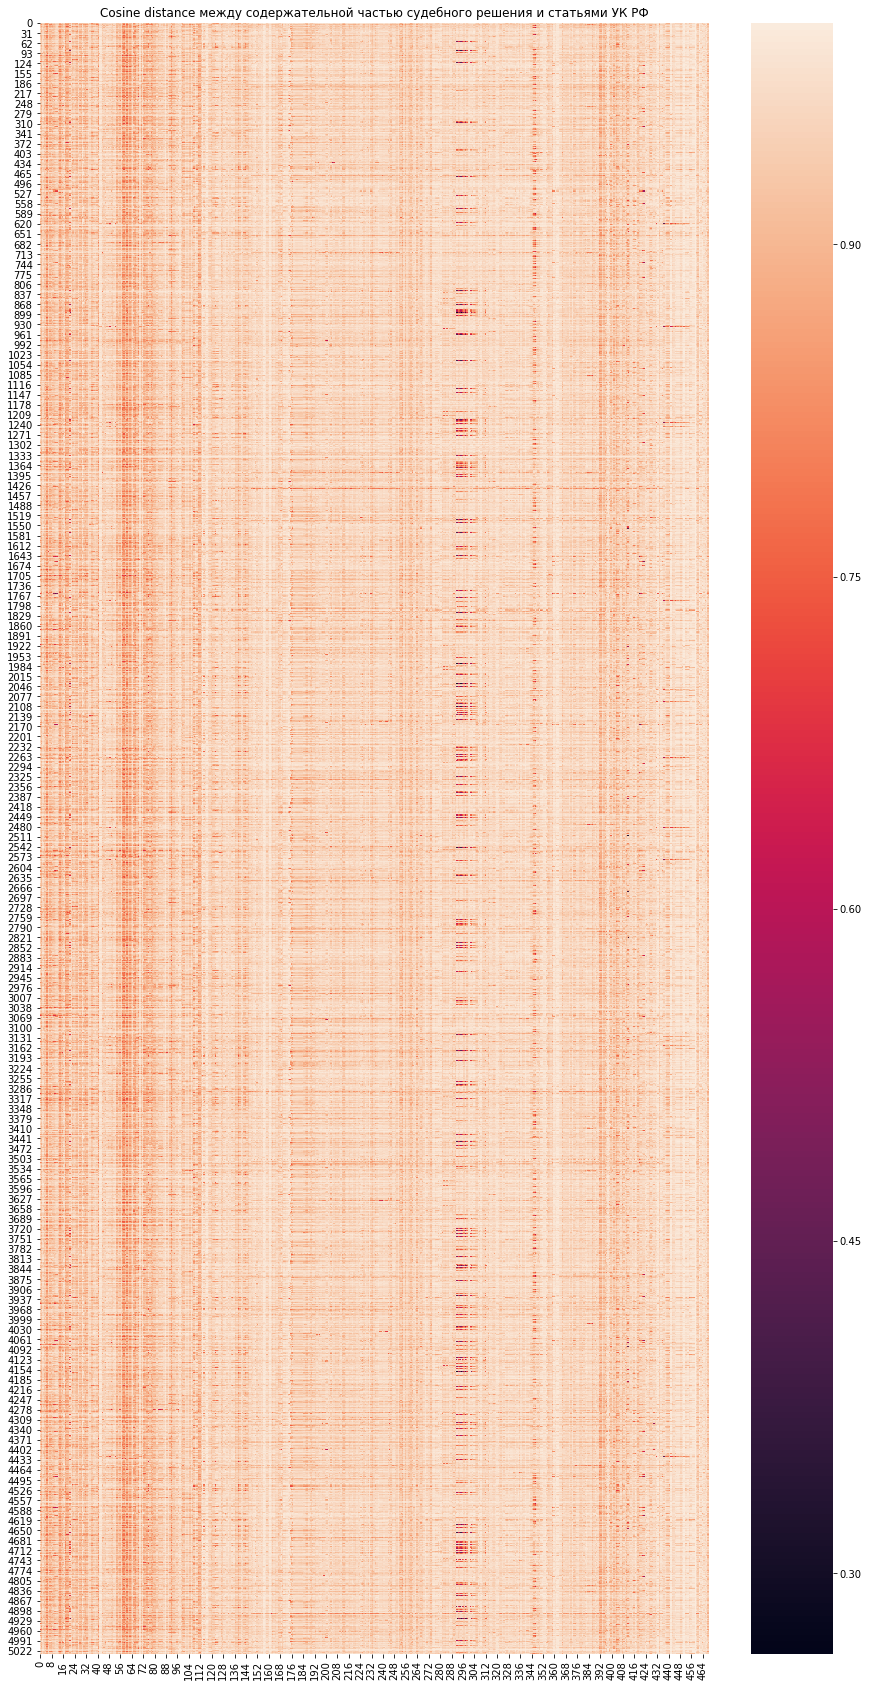

In [18]:
fig, ax = plt.subplots(figsize=(15, 30))
ax.set_title('Cosine distance между содержательной частью судебного решения и статьями УК РФ')
ax = sns.heatmap(distances, ax=ax)

Аномально близкие ко многим делам статьи:

In [19]:
print('\n'.join(['{number}:\t{name}'.format(**text[1]) for text in code.loc[290:300][['number', 'name']].iterrows()]))

226.1:	Контрабанда сильнодействующих, ядовитых, отравляющих, взрывчатых, радиоактивных веществ, радиационных источников, ядерных материалов, огнестрельного оружия или его основных частей, взрывных устройств, боеприпасов, оружия массового поражения, средств его доставки, иного вооружения, иной военной техники, а также материалов и оборудования, которые могут быть использованы при создании оружия массового поражения, средств его доставки, иного вооружения, иной военной техники, а равно стратегически важных товаров и ресурсов или культурных ценностей либо особо ценных диких животных и водных биологических ресурсов
227.0:	Пиратство
228.0:	Незаконные приобретение, хранение, перевозка, изготовление, переработка наркотических средств, психотропных веществ или их аналогов, а также незаконные приобретение, хранение, перевозка растений, содержащих наркотические средства или психотропные вещества, либо их частей, содержащих наркотические средства или психотропные вещества
228.1:	Незаконные произв

In [20]:
num_predictions = 5
for i in range(distances.shape[0]):
    df.loc[i, 'predicted'] = str([code.loc[j, 'number'] for j in distances[i].argsort()[:num_predictions]])

df['predicted'] = df['predicted'].map(eval)
df['labels'] = df['labels'].map(eval)

In [21]:
def intersection(row):
    return len(set(row['labels']).intersection(set(row['predicted'])))

df['intersection'] = df.apply(intersection, axis=1)

In [22]:
def has_intersection(row):
    if len(set(row['labels']).intersection(set(row['predicted']))) > 0:
        return 1
    return 0
df['is_right'] = df.apply(has_intersection, axis=1)

In [23]:
df['is_right'].sum() / df.shape[0]

0.5587358378056052

In [31]:
df[['title', 'labels', 'predicted', 'is_right', 'intersection']].to_csv('results/tf_idf.csv', index=False)
df[['title', 'labels', 'predicted', 'is_right', 'intersection']].head(15)

,title,labels,predicted,is_right,intersection
0,Решение по делу 1-193/2018 - 264 ч.1 - судья Д...,"[264.0, 53.0, 47.0, 317.0]","[76.0, 61.0, 127.1, 132.0, 6.0]",0,0
1,Решение по делу 1-6/2018 - 264.1 - судья Самох...,[264.1],"[264.1, 264.0, 63.0, 23.0, 151.1]",1,1
2,Решение по делу 1-9/2018 - 322.3 - судья Ерохи...,"[264.1, 81.0, 317.0, 259.0]","[264.1, 264.0, 23.0, 63.0, 104.0]",1,1
3,Решение по делу 1-6/2018 - 115 ч.1 - судья Хар...,"[115.0, 317.0]","[39.0, 38.0, 67.0, 76.0, 114.0]",0,0
4,Решение по делу 1-24/2018 - 112 ч.2 п. - судья...,"[112.0, 73.0, 73.0, 317.0]","[11.0, 1.0, 12.0, 60.0, 70.0]",0,0
5,Решение по делу 1-35/2018 - 228 ч.2 - судья Те...,"[228.0, 70.0]","[228.0, 228.3, 229.1, 228.4, 228.2]",1,1
6,Решение по делу 1-6/2018 - 291.2 - судья Митин...,"[291.2, 73.0]","[61.0, 291.2, 63.0, 76.2, 75.0]",1,1
7,Решение по делу 1-5/2018 - 264.1 - судья Усынк...,[264.1],"[264.1, 264.0, 314.1, 23.0, 63.0]",1,1
8,Решение по делу 1-10/2018 - 264.1 - судья Панш...,[264.1],"[264.1, 264.0, 23.0, 63.0, 295.0]",1,1
9,Решение по делу 1-9/2018 - 264.1 - судья Панши...,"[264.1, 70.0, 69.0]","[264.1, 264.0, 70.0, 63.0, 295.0]",1,2
